<a href="https://colab.research.google.com/github/OneNameSam/mlzoomcamp_work/blob/main/Week_4_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [76]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [77]:
df = pd.read_csv(url)
df.columns = df.columns.str.lower()

In [78]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [79]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [80]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


Prepare the numerical variables:

In [81]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [82]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [83]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [84]:
df.dtypes

categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority', 'time', 'age',
       'expenses', 'income', 'assets', 'debt', 'amount', 'default']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [85]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

# del df_train['default']
# del df_val['default']
# del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [86]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score 

numerical_features = ['seniority', 'time', 'income', 'debt']


scores = []

for feature in numerical_features:
  print ('%s %.3f' %(feature, roc_auc_score(df_train['default'], df_train[feature])))

seniority 0.291
time 0.561
income 0.318
debt 0.495


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [87]:
feature_columns= ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

train_dict = df_train[feature_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [88]:
val_dict = df_val[feature_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

round(auc(fpr, tpr),3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [89]:
thresholds = np.linspace(0, 1 ,101)

scores = []

for t in thresholds: 
  actual_postive = (y_val==1)
  actual_negative = (y_val == 0)
  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)
  tp = (predict_positive & actual_postive).sum()
  tn = (predict_negative & actual_negative).sum()
  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_postive).sum()
  scores.append((t, tp,fp,fn, tn))

In [90]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,246,645,0,0
1,0.01,246,635,0,10
2,0.02,244,613,2,32
3,0.03,242,593,4,52
4,0.04,242,563,4,82
...,...,...,...,...,...
96,0.96,0,0,246,645
97,0.97,0,0,246,645
98,0.98,0,0,246,645
99,0.99,0,0,246,645


In [91]:
df_scores["P"] = df_scores.tp/(df_scores.tp + df_scores.fp)
df_scores['R'] = df_scores.tp/(df_scores.tp + df_scores.fn)

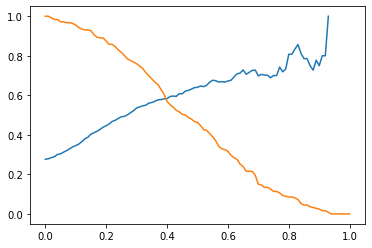

In [92]:
plt.plot(df_scores.threshold, df_scores["P"], label='precision')
plt.plot(df_scores.threshold, df_scores["R"], label='recall')

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

    threshold   tp   fp  fn   tn         P         R        F1
30        0.3  187  162  59  483  0.535817  0.760163  0.628571


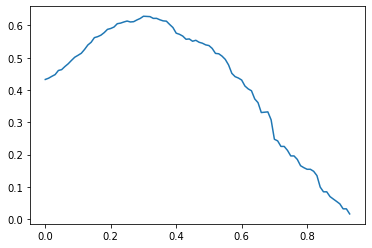

In [93]:
df_scores 
df_scores['F1'] = (2*df_scores.P*df_scores.R )/(df_scores.P + df_scores.R)

plt.plot(df_scores.threshold, df_scores['F1'])

print(df_scores[df_scores['F1']== df_scores['F1'].max()])

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [94]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [95]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[feature_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [96]:
def predict(df, dv, model):
    dicts = df[feature_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [97]:
from tqdm.auto import tqdm

In [98]:
n_splits = 5 
kfold = KFold(n_splits=n_splits , shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.default.values
  y_val = df_val.default.values

  dv, model = train(df_train, y_train) 
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

  print('%.3f' % ( np.std(scores)))

0it [00:00, ?it/s]

0.000
0.000
0.017
0.015
0.014


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [99]:
n_splits = 5 

for C in tqdm([0.01, 0.1, 1, 10]):
  kfold = KFold(n_splits=n_splits , shuffle=True, random_state=1)
  scores = []

  for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=C) 
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores) , np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C=0.01 0.816 +- 0.000
C=0.01 0.818 +- 0.002
C=0.01 0.809 +- 0.014
C=0.01 0.810 +- 0.012
C=0.01 0.808 +- 0.012


0it [00:00, ?it/s]

C=0.1 0.823 +- 0.000
C=0.1 0.824 +- 0.001
C=0.1 0.813 +- 0.016
C=0.1 0.815 +- 0.015
C=0.1 0.813 +- 0.014


0it [00:00, ?it/s]

C=1 0.826 +- 0.000
C=1 0.826 +- 0.000
C=1 0.813 +- 0.017
C=1 0.814 +- 0.015
C=1 0.812 +- 0.014


0it [00:00, ?it/s]

C=10 0.826 +- 0.000
C=10 0.826 +- 0.000
C=10 0.813 +- 0.017
C=10 0.816 +- 0.016
C=10 0.814 +- 0.015


## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.